In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import seaborn as sns
import numpy as np
sns.set(rc={'figure.figsize':(11, 4)})

In [2]:
data = pd.read_pickle("../DATA_COLLECTOR/AGGREGATION_PRODUCTION/aggreg_PRODUCTION_data.pkl")
data.Date = pd.to_datetime(data['Date'],format='%Y%m%d')
data = data.sort_values(by='Date')
data = data[data.Date > '2012-12-31']
data = data.set_index('Date')

display(data.tail())
print(len(data))

,Energy_Generated,Efficiency,Energy_Exported,Energy_Used,Peak_Power,Peak_Time,Condition,Min_Temperature,Max_Temperature,Peak_Energy_Import,Off-Peak_Energy_Import,Shoulder_Energy_Import,High-Shoulder_Energy_Import,Insolation
Date,,,,,,,,,,,,,,
2019-04-25,3144,2.911,2977,0,984,13:20,Partly Cloudy,9,22,NaN,NaN,NaN,NaN,6308
2019-04-26,2715,2.514,2399,0,985,16:40,Partly Cloudy,3,17,NaN,NaN,NaN,NaN,6315
2019-04-27,2477,2.294,2049,0,1041,15:40,Partly Cloudy,7,20,NaN,NaN,NaN,NaN,6323
2019-04-28,3788,3.507,3693,0,963,13:00,Fine,7,21,NaN,NaN,NaN,NaN,6330
2019-04-29,3265,3.023,2706,0,1010,13:50,Partly Cloudy,3,24,NaN,NaN,NaN,NaN,6336


2259


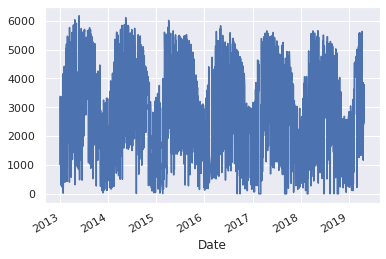

In [4]:
data.Energy_Generated = pd.to_numeric(data.Energy_Generated)
data.Energy_Generated.plot()

In [4]:
data['month'] = data.index.month
data['year'] = data.index.year
data['Weekday_Name'] = data.index.day_name
#data = data.reset_index()
#data

**Choose a date threshold to separate training and testing data**

In [5]:
thresh_date = '2018-12-31' #'2019-02-07', '2019-08-31'
train_data = data[data.index < thresh_date]
test_data = data[data.index > thresh_date]
display(train_data.head(2))
display(test_data.head(2))

print("Train size %d, test size %d" % (len(train_data), len(test_data)))

,Energy_Generated,Efficiency,Energy_Exported,Energy_Used,Peak_Power,Peak_Time,Condition,Min_Temperature,Max_Temperature,Peak_Energy_Import,Off-Peak_Energy_Import,Shoulder_Energy_Import,High-Shoulder_Energy_Import,Insolation,month,year,Weekday_Name
Date,,,,,,,,,,,,,,,,,
2013-01-01,1013,0.938,998,0,807,13:10,Showers,8,13,NaN,NaN,NaN,NaN,3458,1,2013,<bound method PandasDelegate._add_delegate_acc...
2013-01-02,2878,2.665,2840,0,837,13:00,Mostly Cloudy,7,13,NaN,NaN,NaN,NaN,3472,1,2013,<bound method PandasDelegate._add_delegate_acc...


,Energy_Generated,Efficiency,Energy_Exported,Energy_Used,Peak_Power,Peak_Time,Condition,Min_Temperature,Max_Temperature,Peak_Energy_Import,Off-Peak_Energy_Import,Shoulder_Energy_Import,High-Shoulder_Energy_Import,Insolation,month,year,Weekday_Name
Date,,,,,,,,,,,,,,,,,
2019-01-01,2022,1.872,1637,0,744,13:05,Fine,-2,9,NaN,NaN,NaN,NaN,3243,1,2019,<bound method PandasDelegate._add_delegate_acc...
2019-01-02,277,0.256,88,0,116,14:40,Showers,2,4,NaN,NaN,NaN,NaN,3255,1,2019,<bound method PandasDelegate._add_delegate_acc...


Train size 2139, test size 119


**Resample data (month aggregation)**

Date
2013-01-31    1567.161290
2013-02-28    2438.821429
2013-03-31    3316.366667
2013-04-30    3445.241379
2013-05-31    2819.000000
                 ...     
2018-08-31    3514.766667
2018-09-30    3503.866667
2018-10-31    1807.322581
2018-11-30    1729.866667
2018-12-31    1536.466667
Freq: M, Name: Energy_Generated, Length: 72, dtype: float64

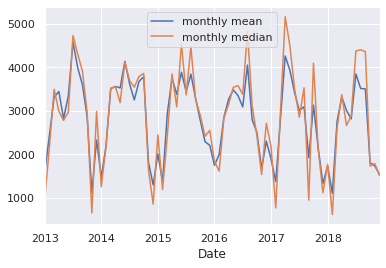

In [6]:
#monthly_data_mean = data.groupby(['year','month']).mean().reset_index()
all_monthly_data_mean = data.Energy_Generated.resample('M').mean()
monthly_data_mean = train_data.Energy_Generated.resample('M').mean()
weekly_data_mean = train_data.Energy_Generated.resample('W').mean()
monthly_data_median = train_data.Energy_Generated.resample('M').median()
monthly_data_sum = train_data.Energy_Generated.resample('M').sum()
display(monthly_data_mean)

monthly_data_mean.plot(label='monthly mean')
monthly_data_median.plot(label='monthly median')
plt.legend()

In [7]:
M_train_size = len(monthly_data_mean)
print(M_train_size)

72


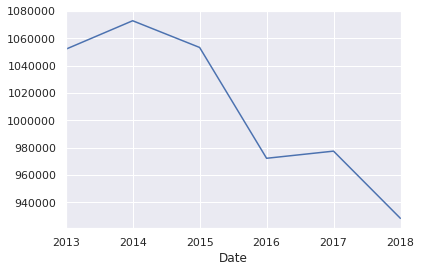

In [8]:
annual_data_sum = train_data.Energy_Generated.resample('A').sum()
annual_data_sum.plot()

**Rolling window**

Date
2019-04-12    3144.392857
2019-04-13    3055.357143
2019-04-14    2973.750000
2019-04-15    2967.892857
2019-04-16    2971.892857
Name: Energy_Generated, dtype: float64


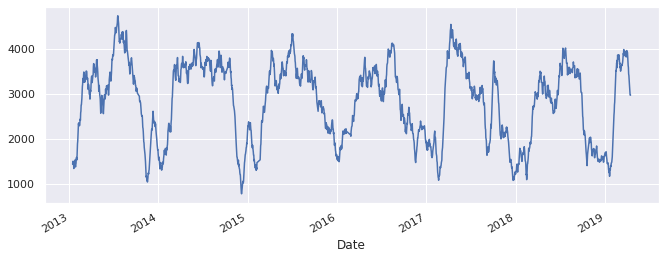

In [24]:
energy_28d = data.Energy_Generated.rolling(28, center=True).mean()
energy_365d = train_data.Energy_Generated.rolling(window=365, center=True, min_periods=360).mean()
energy_28d = energy_28d.dropna()
energy_28d.plot()
print(energy_28d.tail())

**Stationarity study**

<Figure size 432x288 with 0 Axes>

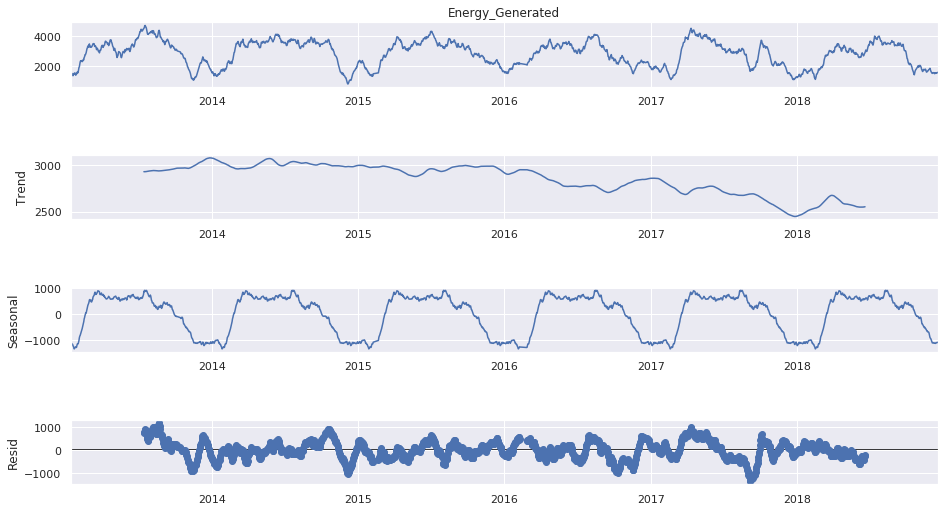

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
energy_28d = energy_28d.dropna()
decomposition = seasonal_decompose(energy_28d,period=360) 

fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [9]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):  
    #Determing rolling statistics
    rolmean = timeseries.rolling(12, center=True).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig  = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std  = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


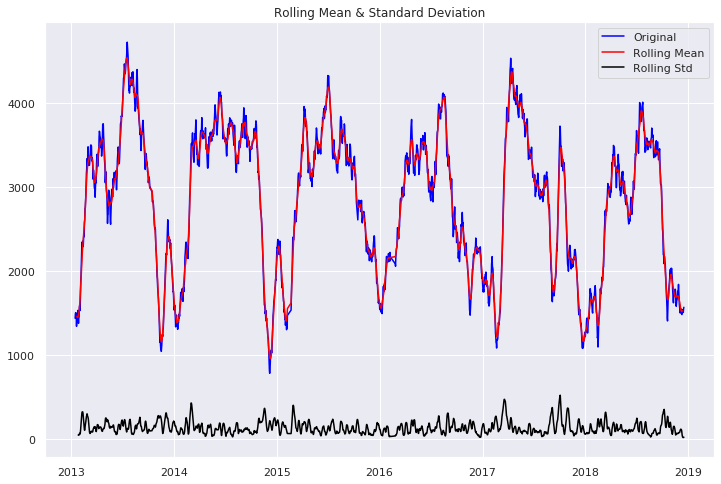

Results of Dickey-Fuller Test:
Test Statistic                   -4.903502
p-value                           0.000034
#Lags Used                       19.000000
Number of Observations Used    2092.000000
Critical Value (1%)              -3.433480
Critical Value (5%)              -2.862923
Critical Value (10%)             -2.567506
dtype: float64


In [10]:
test_stationarity(energy_28d)

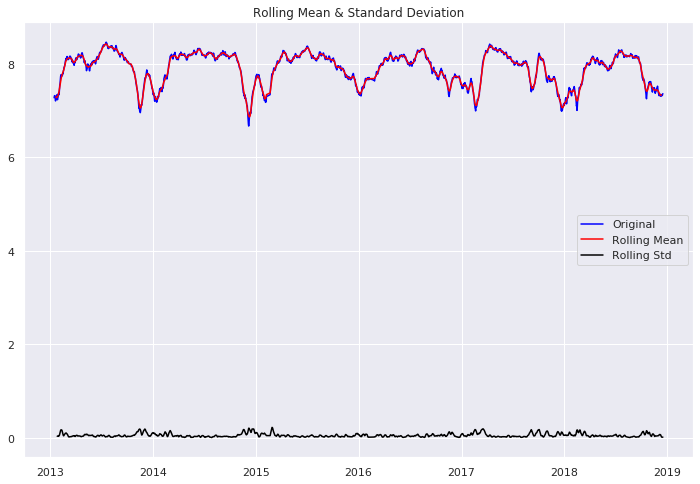

Results of Dickey-Fuller Test:
Test Statistic                   -4.186335
p-value                           0.000695
#Lags Used                       24.000000
Number of Observations Used    2087.000000
Critical Value (1%)              -3.433487
Critical Value (5%)              -2.862926
Critical Value (10%)             -2.567508
dtype: float64


In [29]:
energy_28d_log = energy_28d.apply(lambda x: np.log(x))  
test_stationarity(energy_28d_log)

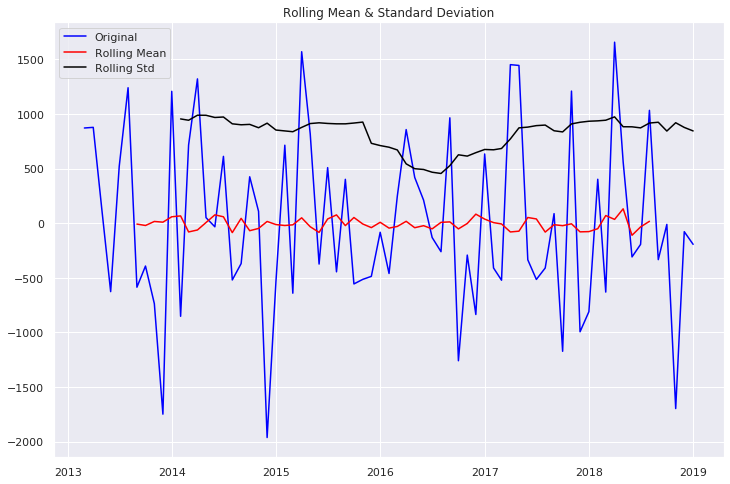

Results of Dickey-Fuller Test:
Test Statistic                -5.785933e+00
p-value                        4.999591e-07
#Lags Used                     1.200000e+01
Number of Observations Used    5.800000e+01
Critical Value (1%)           -3.548494e+00
Critical Value (5%)           -2.912837e+00
Critical Value (10%)          -2.594129e+00
dtype: float64


In [15]:
monthly_data_mean_first_diff = monthly_data_mean - monthly_data_mean.shift(1)  
test_stationarity(monthly_data_mean_first_diff.dropna(inplace=False))

In [36]:
energy_28d_log_seasonal_first_difference = energy_28d_log - energy_28d_log.shift(365)  
#test_stationarity(monthly_data_mean_seasonal_first_difference.dropna(inplace=False))

In [41]:
energy_28d_log_seasonal_first_difference_first_diff = energy_28d_log_seasonal_first_difference - energy_28d_log_seasonal_first_difference.shift(1)  
#test_stationarity(monthly_data_mean_first_diff.dropna(inplace=False))

**Autocorrelation study**

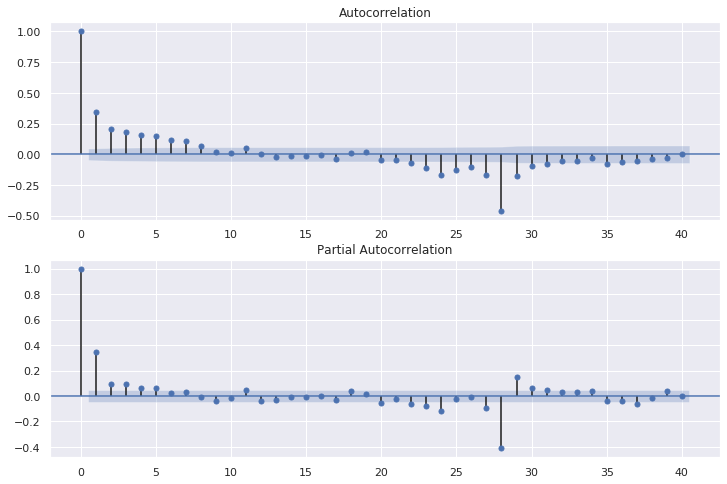

In [42]:
import statsmodels.api as sm 

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(energy_28d_log_seasonal_first_difference_first_diff.iloc[365:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(energy_28d_log_seasonal_first_difference_first_diff.iloc[365:], lags=40, ax=ax2)

Text(0.5, 1.0, 'Trends in Generated Energy')

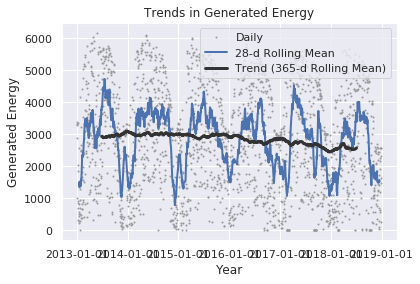

In [18]:
import matplotlib.dates as mdates

# Plot daily, 28-day rolling mean, and 365-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(train_data.Energy_Generated, marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')
ax.plot(energy_28d, linewidth=2, label='28-d Rolling Mean')
ax.plot(energy_365d, color='0.2', linewidth=3,
label='Trend (365-d Rolling Mean)')
# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Generated Energy')
ax.set_title('Trends in Generated Energy')

[1441.25       1494.53571429 1507.46428571 ... 1510.78571429 1553.71428571
 1572.17857143]


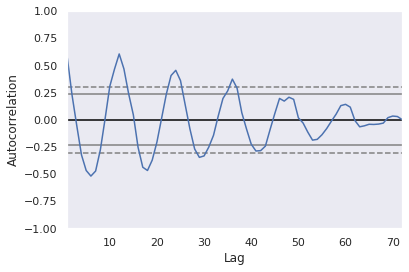

In [19]:
from pandas.plotting import autocorrelation_plot
energy_28d = energy_28d.dropna()
autocorrelation_plot(monthly_data_mean)
print(energy_28d.values)

##Boxplot
boxplot = False
if boxplot:
    years = range(2013,2020,1)
    fig, axes = plt.subplots(len(years), 1, figsize=(11, 10), sharex=True)
    for name, ax in zip(years, axes):
        new_data = pd.DataFrame()
        new_data['month'] = data[(data.year == name)].month.values
        new_data['Weekday_Name'] = data[(data.year == name)]['Weekday_Name'].values
        new_data['generated_energy'] = data[(data.year == name)].Energy_Generated.values
        ax = sns.boxplot(data=new_data, x='month',y="generated_energy",ax=ax)
        ax.set_ylabel('energy')
        ax.set_title(str(name))
        if ax != axes[-1]:
            ax.set_xlabel('')

In [20]:
monthly_data_mean.count()

72

**SARIMA forecasting**

In [ ]:
mod = sm.tsa.statespace.SARIMAX(energy_28d[:-15], trend='n', order=(0,1,2), seasonal_order=(0,1,2,365))
results = mod.fit()
print(results.summary())

/home/zhe/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/zhe/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/zhe/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


count      72.000000
mean      -59.001936
std       671.045594
min     -1947.453487
25%      -535.864931
50%       -23.455840
75%       394.676036
max      1567.161290
dtype: float64


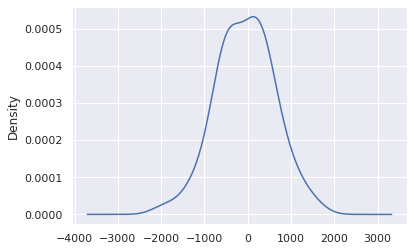

In [22]:
residuals = results.resid
#residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [23]:
test_monthly_data_mean = test_data.Energy_Generated.resample('M').mean()
M_test_size = len(test_monthly_data_mean)
print(M_test_size)

4


In [12]:
end   = M_test_size + M_train_size
start = M_train_size

NameError: name 'M_test_size' is not defined

2019-01-31    1532.279821
2019-02-28    1392.514078
2019-03-31    2704.387977
2019-04-30    3404.258617
2019-05-31    3191.409038
Freq: M, dtype: float64


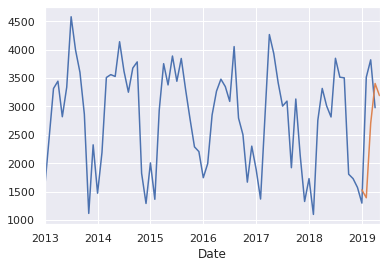

In [24]:
forecast_values = results.predict(start=start, end=end, dynamic=True)
all_monthly_data_mean.plot()
forecast_values.plot()

print(forecast_values)

In [25]:
from sklearn.metrics import mean_squared_error

print(pd.concat([forecast_values, test_monthly_data_mean], axis=1, sort=False))
rmse = mean_squared_error(test_monthly_data_mean.values, forecast_values.values[:M_test_size],squared=False) #**1/2 was evaluated as *0.5 and not pow(0.5)
print("RMSE = %d" % rmse) 

                      0  Energy_Generated
2019-01-31  1532.279821       1298.419355
2019-02-28  1392.514078       3514.285714
2019-03-31  2704.387977       3820.903226
2019-04-30  3404.258617       2978.137931
2019-05-31  3191.409038               NaN
RMSE = 1223


**Holt Winter’s Exponential Smoothing (HWES) forecast**

In [25]:
print(energy_28d.shape)

(2232,)


/home/zhe/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/zhe/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


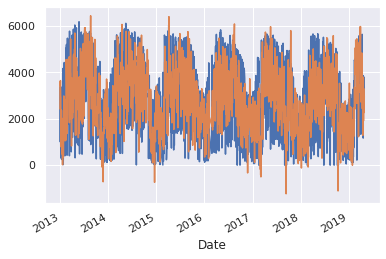

In [6]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# fit model
model = ExponentialSmoothing(data.Energy_Generated, seasonal='add', seasonal_periods=360,trend='add')
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(start=0, end=2258)
data.Energy_Generated.plot()
#print(yhat)
yhat.plot()

(2259,) (2259,)
RMSE = 1384


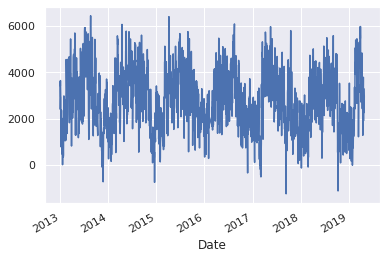

In [10]:
from sklearn.metrics import mean_squared_error
yhat.plot()
print(data.Energy_Generated.shape,yhat.shape)
#print(pd.concat([yhat, energy_28d[2000:2111]], axis=1, sort=False))
rmse = mean_squared_error(data.Energy_Generated.values, yhat[:].values,squared=False)
print("RMSE = %d" % rmse) 

<class 'pandas.core.series.Series'>
count    2232.000000
mean       -0.018937
std        79.761783
min      -326.176473
25%       -52.399518
50%         0.139714
75%        50.143433
max       348.170999
dtype: float64


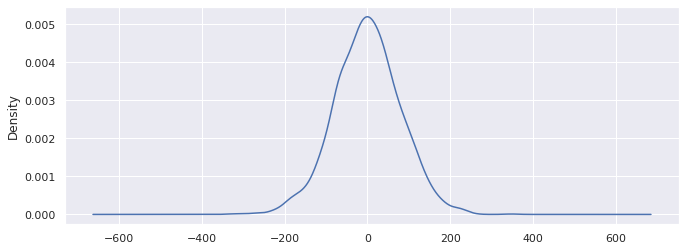

In [32]:
residuals = model_fit.resid
print(type(residuals))
residuals.plot(kind='kde')
print(residuals.describe())
residuals.

**Facebook Prophet model forecast**

In [33]:
from fbprophet import Prophet

In [53]:
monthly_data_mean = monthly_data_mean.reset_index()
monthly_data_mean = monthly_data_mean.rename(columns={'Date': 'ds','Energy_Generated': 'y'})

In [123]:
weekly_data_mean = weekly_data_mean.reset_index()
weekly_data_mean = weekly_data_mean.rename(columns={'Date': 'ds','Energy_Generated': 'y'})

In [34]:
energy_28d = energy_28d.reset_index()
energy_28d = energy_28d.rename(columns={'Date': 'ds','Energy_Generated': 'y'})
energy_28d = energy_28d.dropna()

In [35]:
#Prophet
model=Prophet(interval_width=0.95, yearly_seasonality=True)

In [36]:
model.fit(energy_28d)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/zhe/.local/lib/python3.6/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



In [45]:
print(energy_28d)
future_dates = model.make_future_dataframe(periods=1,include_history=True)
forecast = model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

             ds            y
0    2013-01-15  1441.250000
1    2013-01-16  1494.535714
2    2013-01-17  1507.464286
3    2013-01-18  1478.892857
4    2013-01-19  1446.750000
...         ...          ...
2227 2019-04-12  3144.392857
2228 2019-04-13  3055.357143
2229 2019-04-14  2973.750000
2230 2019-04-15  2967.892857
2231 2019-04-16  2971.892857

[2232 rows x 2 columns]


/home/zhe/.local/lib/python3.6/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



(2233, 4)

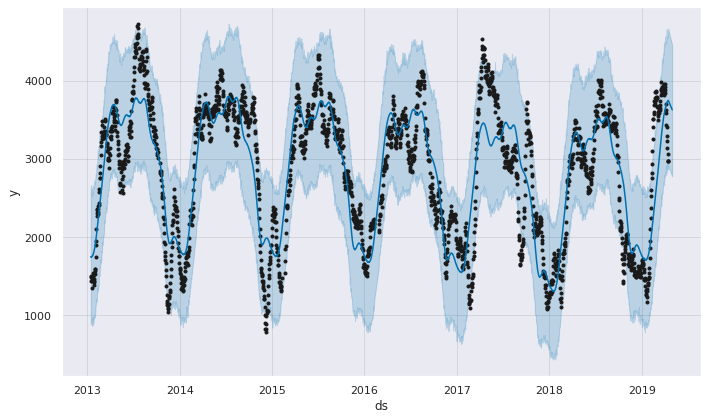

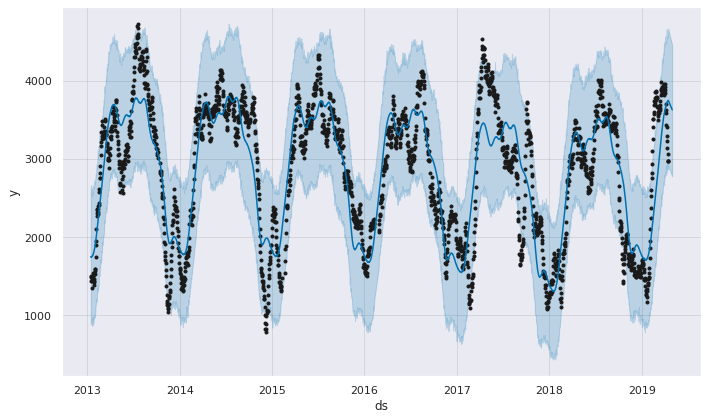

In [38]:
model.plot(forecast,uncertainty=True)

/home/zhe/.local/lib/python3.6/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



AttributeError: 'DatetimeIndex' object has no attribute 'weekday_name'

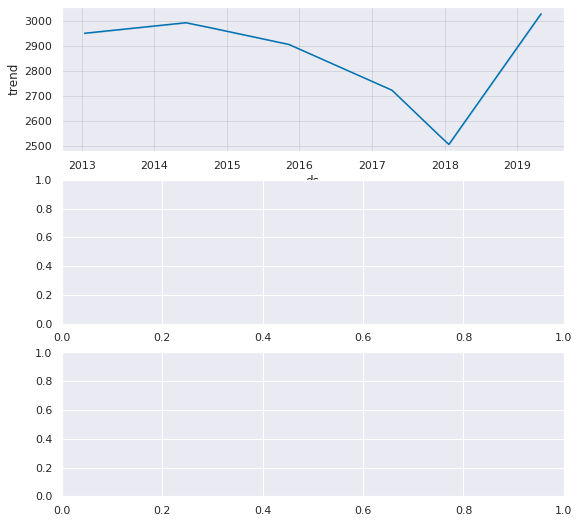

In [39]:
model.plot_components(forecast)

In [40]:
print(pd.concat([yhat, test_monthly_data_mean], axis=1, sort=False))
rmse = mean_squared_error(test_monthly_data_mean.values, forecast[['yhat']].tail(M_test_size).values,squared=False)
print("RMSE = %d" % rmse) 

NameError: name 'test_monthly_data_mean' is not defined

### Bayesian dynamic linear model

In [90]:
#energy_28d = energy_28d.to_frame()
energy_28d = energy_28d.reset_index()
print(energy_28d)

           Date  Energy_Generated
0    2013-01-15       1441.250000
1    2013-01-16       1494.535714
2    2013-01-17       1507.464286
3    2013-01-18       1478.892857
4    2013-01-19       1446.750000
...         ...               ...
2107 2018-12-13       1533.392857
2108 2018-12-14       1529.321429
2109 2018-12-15       1510.785714
2110 2018-12-16       1553.714286
2111 2018-12-17       1572.178571

[2112 rows x 2 columns]


Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


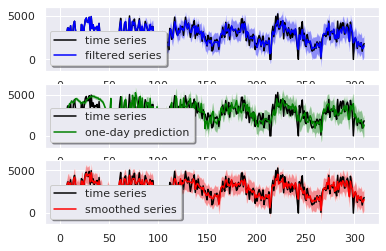

In [121]:
#Bayesian
#monthly_data_mean = train_data.Energy_Generated.resample('M').mean()
#energy_28d = energy_28d.dropna()
weekly_data_mean = weekly_data_mean.dropna()
from pydlm import dlm, trend, seasonality
# A linear trend
linear_trend = trend(degree=1, discount=0.95, name='linear_trend', w=10)
# A seasonality
seasonal12 = seasonality(period=52, discount=0.99, name='year', w=100)
# Build a simple dlm
simple_dlm = dlm(weekly_data_mean) + linear_trend + seasonal12
# Fit the model
simple_dlm.fit()
# Plot the fitted results
#simple_dlm.turnOff('data points')
simple_dlm.plot()

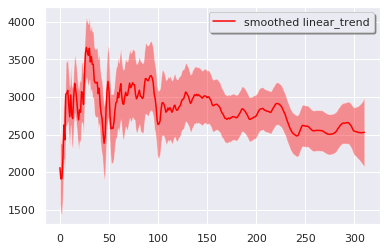

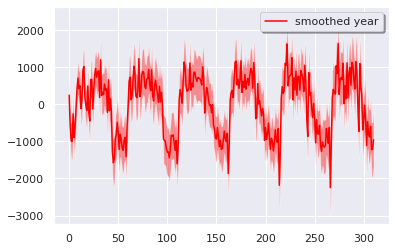

In [122]:
simple_dlm.turnOff('predict plot')
simple_dlm.turnOff('filtered plot')
simple_dlm.plot('linear_trend')
simple_dlm.plot('year')

In [104]:
simple_dlm.plotPredictN(date=2100, N=3)

NameError: Prediction can only be made right after the filtered date

In [60]:
forecast_values = simple_dlm.predictN(date=71, N=M_test_size)[0][:M_test_size]
print(forecast_values)

0     1479.351981
1     1338.499528
2     2656.248270
3     3295.771142
4     3068.467506
5     3104.125593
6     3190.406462
7     3243.112227
8     2727.486372
9     2400.702570
10    1511.473875
11    1471.643638
12    1372.709570
13    1231.857117
Name: forecast, dtype: float64


In [64]:
rmse = mean_squared_error(test_monthly_data_mean.values, forecast_values,squared=False)
print("RMSE = %d" % rmse) 

RMSE = 999
